# ALGORITMOS DE POTENCIACIÓN

In [61]:
# Importaciones necesarias
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import *
from imblearn.metrics import specificity_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import XGBClassifier
import pickle
from sklearn import tree
import joblib

## Paso 1: Cargar del conjunto de datos

In [3]:
# Cargar los datasets de entrenamiento y testeo analizados en el proyecto anterior
with open('../data/processed/X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('../data/processed/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open('../data/processed/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('../data/processed/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [4]:
# Valido los tamaños de los dataframes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(614, 6)
(154, 6)
(614,)
(154,)


## Paso 2: Construir un modelo de boosting

### Modelo Boosting

In [36]:
# Inicializamos el modelo
modelo_boosting = XGBClassifier(n_estimators = 100, max_depth = 10, learning_rate = 0.3, random_state = 42)
modelo_boosting.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [37]:
# Hacemos las predicciones con la porcion de test
y_pred = modelo_boosting.predict(X_test)
y_pred

array([0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0])

In [38]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [39]:
# Realizamos predicciones en el conjunto de entrenamiento y prueba
test_pred = modelo_boosting.predict(X_test)
train_pred = modelo_boosting.predict(X_train)

# Evaluamos el rendimiento del modelo
get_metrics(y_train, y_test, train_pred, test_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Test,0.733766,0.655462,0.728283,0.609375,0.709091,0.747475
Diferencia,0.266234,0.344538,0.271717,0.390625,0.290909,0.252525


### Mejora de hiperparamentros

In [51]:
#Busqueda random de mejores hiperparametros
hyperpa = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
}

xgb = XGBClassifier(eval_metric='auc')
random_search = RandomizedSearchCV(xgb, param_distributions=hyperpa, n_iter=50, scoring='accuracy', cv=5, verbose=0)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrai...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=50,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 300, 500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='accuracy')

In [52]:
print(random_search.best_score_)
print(random_search.best_params_)

0.783406637345062
{'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01}


In [69]:
# Inicializamos el modelo
modelo_boosting2 = XGBClassifier(n_estimators = 300, max_depth = 3, subsample = 1, learning_rate = 0.01, random_state = 42)
modelo_boosting2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [70]:
# Hacemos las predicciones con la porcion de test
y_pred2 = modelo_boosting2.predict(X_test)
y_pred2

array([0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [71]:
# Realizamos predicciones en el conjunto de entrenamiento y prueba
test_pred2 = modelo_boosting2.predict(X_test)
train_pred2 = modelo_boosting2.predict(X_train)

# Evaluamos el rendimiento del modelo
get_metrics(y_train, y_test, train_pred2, test_pred2)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.830619,0.740000,0.798789,0.791444,0.694836,0.902743
Test,0.759740,0.647619,0.728283,0.680000,0.618182,0.838384
Diferencia,0.070879,0.092381,0.070507,0.111444,0.076654,0.064359


## Paso 3: Guardar el modelo

In [55]:
# Guardar los modelos
joblib.dump(modelo_boosting2, '../models/modelo_boosting2.pkl')
joblib.dump(modelo_boosting, '../models/modelo_boosting.pkl')

['../models/modelo_boosting.pkl']

## Paso 4: Analizar y comparar los resultados de los modelos

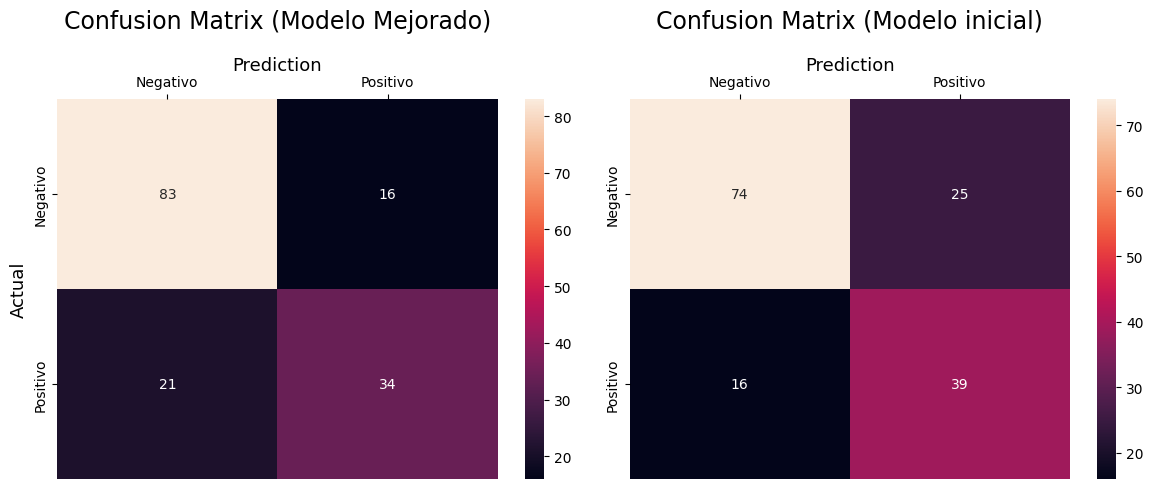

In [60]:
# Calcular las matrices de confusión para ambos modelos
cm_model = confusion_matrix(y_test, test_pred)  # Matriz de confusión del modelo
cm_modelo2 = confusion_matrix(y_test, test_pred2)    # Matriz de confusión del modelo2 mejorado

# Crear una figura con dos subgráficos lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

# Gráfico 1: Matriz de confusión del modelo complejo (izquierda)
sns.heatmap(cm_modelo2, 
            annot=True, 
            fmt='g', 
            xticklabels=['Negativo', 'Positivo'], 
            yticklabels=['Negativo', 'Positivo'], 
            ax=ax1)
ax1.set_ylabel('Actual', fontsize=13)
ax1.set_title('Confusion Matrix (Modelo Mejorado)', fontsize=17, pad=20)
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Prediction', fontsize=13)
ax1.xaxis.tick_top()

# Gráfico 2: Matriz de confusión del modelo simple (derecha)
sns.heatmap(cm_model, 
            annot=True, 
            fmt='g', 
            xticklabels=['Negativo', 'Positivo'], 
            yticklabels=['Negativo', 'Positivo'], 
            ax=ax2)
ax2.set_title('Confusion Matrix (Modelo inicial)', fontsize=17, pad=20)
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Prediction', fontsize=13)
ax2.xaxis.tick_top()

# Ajustar el espaciado entre los gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

> Analisis: Se obtiene mejora del modelo optimizado con busqueda random, obteniendo una exactitud de 0.759740 frente a 0.733766 obtenida inicialmente, sin embargo el modelo inicial predice mejor los positivos.

| Modelo         | Accuracy | F1 Score | AUC     |
|----------------|----------|----------|---------|
| Árbol simple   | 0.74026  | 0.74026  | 0.69293 |
| Árbol complejo | 0.74675  | 0.61386  | 0.70606 |
| Random Forest  | 0.77273  | 0.69026  | 0.75859 |
| XGBoost        | 0.73377  | 0.65546  | 0.72828 |
| XGBoost2       | 0.75974  | 0.64762  | 0.72828 |

Se debe tener en cuenta que este es un dataset desvalanceado, es decir tiene mayor proporcion de una clase que de otra en su variable objetivo, y tambien que es algo pequeño, por lo tanto pudiera ser que no es necesario un modelo tan robusto como el de Boosting, en este caso, se puede concluir que las mejores metricas se han obtenido en el modelo random de arbol de decisión.